In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from src.swan import SWAN
from src.utils import rebin_time
from tricorder.procedure_codesets import cabg_names, icu_codes, aortic_names, valve_surgeries
import datapane as dp

from src.cohort_metrics import Metric, OxygenDelivery, CardiacPower, compute_o2_content, OxygenConsumption, pivot_tidy, melt_tidy
from src.cohort_metrics import VentricularStrokeWorkIndex

In [3]:
swan = SWAN('/Users/elijahc/data/compass/SWAN/')
# eids = swan.procedures.sel(order_name=cabg_names).encounter_id.unique()

In [4]:
class Pulsatility(Metric):
    shortname = "Pulsatility"
    classname = 'Pulsatility'
    REQUIRES = {
        'flowsheet' : ['BP']
    }
    
    def __init__(self, db, encounter_id=None):
        super(Pulsatility,self).__init__(db, encounter_id)
    
    def after_flowsheet_sel(self,df):
        df = df[df.flowsheet_value.str.contains('/')]
        bp = [s.split('/') for s in df.flowsheet_value.values]
        bp = pd.DataFrame(bp,columns=['SBP','DBP'])
        df = df.drop(columns=['display_name','flowsheet_value'])
        df['display_name'] = 'SBP'
        df['flowsheet_value'] = bp.SBP
        dbp = df.copy()
        dbp.display_name = 'DBP'
        dbp.flowsheet_value = bp.DBP
        
        return pd.concat([df.reset_index(),dbp.reset_index()])
        
    def _prep(self, sample=None, encounter_id=None):
        if sample is not None and isinstance(sample, int):    
            components = self.db_sample(n=sample).dropna().sort_values(['encounter_id','time'])
        elif sample is not None and isinstance(sample, (list, type(np.array([])), type(pd.Series()))):
            components = self.db_fetch(encounter_id=sample)
        else:
            components = self.db_fetch()
        return pivot_tidy(components,t='time')
    
    def compute(self, sample=None, with_components=False, encounter_id=None):
        pvdf = self._prep(sample=sample, encounter_id=encounter_id)
        pvdf['pulsatility'] = pvdf.SBP-pvdf.DBP
        if not with_components:
            return pvdf['pulsatility'].reset_index().rename(columns={'pulsatility':'value'})
        else:
            return pvdf

In [5]:
pc = swan.create_procedure_cohort(procedures=cabg_names+aortic_names+valve_surgeries)


In [6]:
pc.add_continuous_metric(VentricularStrokeWorkIndex)
pc.add_continuous_metric(OxygenConsumption)
pc.add_continuous_metric(OxygenDelivery)
pc.add_continuous_metric(CardiacPower)

CohortMetrics
- VentricularStrokeWorkIndex
- OxygenConsumption
- OxygenDelivery
- CardiacPower


[VentricularStrokeWorkIndex, OxygenConsumption, OxygenDelivery, CardiacPower]

In [7]:
cp = pc.metrics.CardiacPower.compute()
cp = pc.align_metric(cp)
cp = cp.query('name == "Cardiac Power"')

  0%|          | 0/2072 [00:00<?, ?it/s]

In [8]:
rv = pc.metrics.VentricularStrokeWorkIndex.compute()
rv = pc.align_metric(rv)
rv = rv.query('name == "RVSWI"')

  0%|          | 0/2072 [00:00<?, ?it/s]

In [9]:
vo = pc.metrics.OxygenConsumption.compute()
vo = pc.align_metric(vo)
vo = vo.query('name == "VO2_I"')

  0%|          | 0/2072 [00:00<?, ?it/s]

In [10]:
do = pc.metrics.OxygenDelivery.compute()
do = pc.align_metric(do)
do = do.query('name == "DO2_I"')

  0%|          | 0/2071 [00:00<?, ?it/s]

In [11]:
dl = pc.labs(names=['TCO2 VENOUS','TCO2 ARTERIAL',
                    'BASE EXCESS VENOUS','BASE EXCESS ARTERIAL',
                    'BICARBONATE ARTERIAL',
                    'PH ARTERIAL','PH VENOUS',
                   ])
dl = pc.align_metric(dl)
# dl = dl.dropna().merge(pc.mortality, on='encounter_id', how='left')
dl
# df = rebin_time(df,on='day')

,encounter_id,time,name,value,offset
0,36646194667,0 days 10:12:00,TCO2 VENOUS,24.0,13903
1,36646194667,0 days 11:48:00,TCO2 VENOUS,25.0,13903
2,36646194667,0 days 12:21:00,TCO2 VENOUS,25.0,13903
3,36646194667,0 days 13:06:00,TCO2 VENOUS,25.0,13903
4,36646194667,0 days 13:34:00,TCO2 VENOUS,24.0,13903
...,...,...,...,...,...
48733,169134840724,0 days 09:30:00,BASE EXCESS VENOUS,-1.5,20544
48734,169134840724,0 days 10:15:00,BASE EXCESS VENOUS,-3.1,20544
48735,169437660419,0 days 10:15:00,BASE EXCESS VENOUS,-0.6,16072
48736,169887752836,0 days 11:32:00,BASE EXCESS VENOUS,4.7,27652


In [14]:
df = rebin_time(pd.concat([vo,do,cp,rv,dl.query('name == "BASE EXCESS VENOUS"')]),on='q12h')

df = df.dropna().merge(pc.mortality, on='encounter_id', how='left')
print(df.name.value_counts())
df = df.groupby(['death','encounter_id','btime','name']).value.agg('mean').reset_index()
df = df.query('btime >= -1 & btime <= 200')

RVSWI                 111589
Cardiac Power          99354
DO2_I                  34474
VO2_I                  34401
BASE EXCESS VENOUS      6941
Name: name, dtype: int64


/Applications/JupyterLab.app/Contents/Resources/jlab_server/lib/python3.8/site-packages/numpy/lib/function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


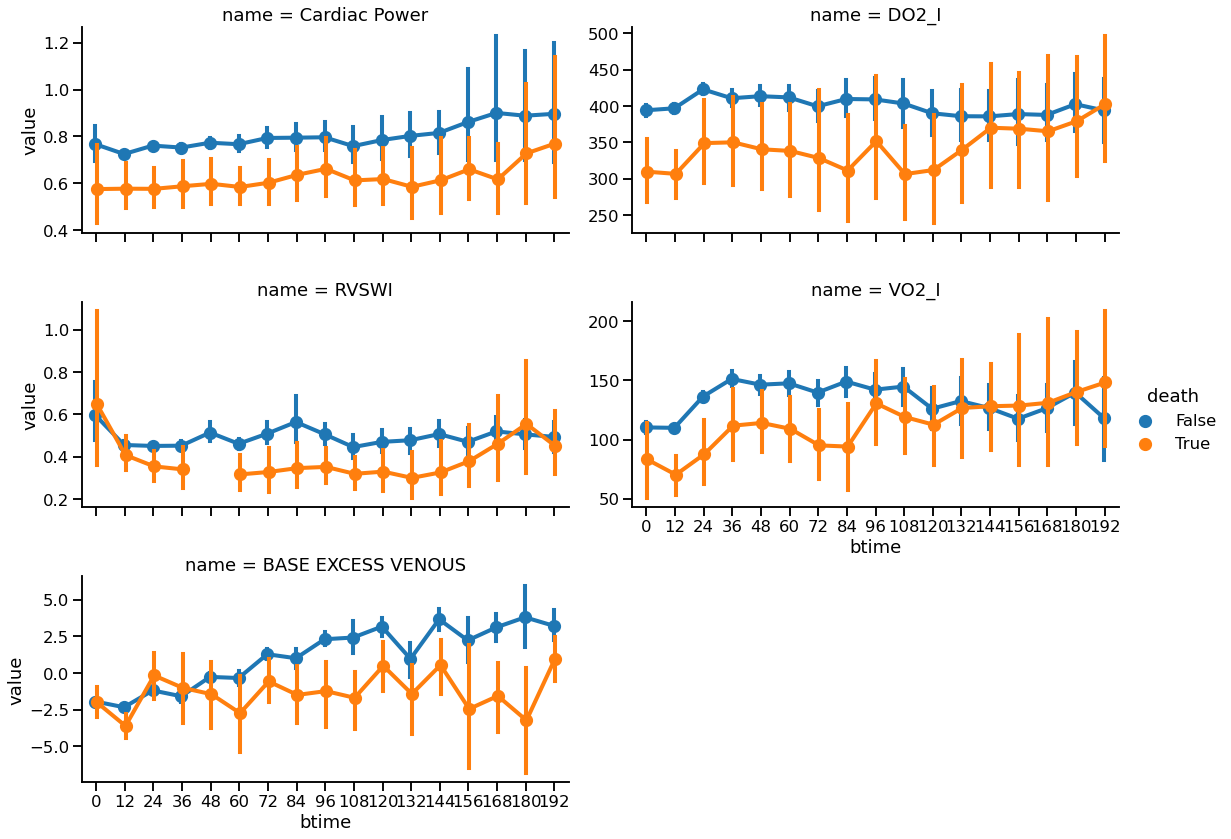

In [15]:
sns.set_context('talk')
g = sns.catplot(x='btime',y='value',hue='death',col='name',col_wrap=2,
                data=df.astype({'btime':int}),kind='point',height=4,aspect=2,
                sharey=False,dodge=True)
# g.set_ylabel('ml/min/m^2')
# g.set_xlabel('Time (hours)')

In [21]:
df['time'] = pd.to_timedelta(df.btime,unit='day')
pv = pivot_tidy(df).reset_index()

In [22]:
dp.login(token='1e468aeafdb74e9af136ebe57e2dfcf4d16cbbbf')

Connected successfully to https://datapane.com as elijahc


'elijahc'

In [ ]:
sns.set_style('whitegrid')
lab = "BASE EXCESS VENOUS"
df = df.query('name == "{}"'.format(lab)).groupby(['death','encounter_id','btime']).value.agg('mean').reset_index()
df = df.query('btime >= -24 & btime <= 250')
g = sns.lineplot(x='btime',y='value',hue='death',data=df)
g.set_title(lab)
g.set_ylabel(lab)

Text(0, 0.5, 'Num unique encounters')

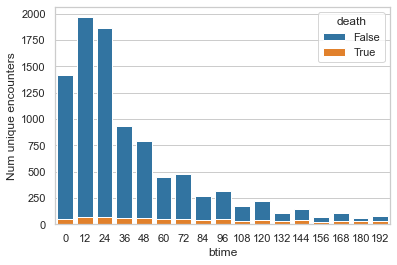

In [29]:
sns.set_context('notebook')
sns.set_style('whitegrid')
# sns.set(rc={'figure.figsize':(15,8)})
btimes = df.groupby(['btime','death']).agg({'encounter_id':'nunique'}).reset_index().astype({'btime':int})
g_b = sns.barplot(data=btimes,x='btime',y='encounter_id',hue='death',dodge=False)
g_b.set_ylabel('Num unique encounters')

In [30]:
rep = dp.Report(
    dp.Text("ICU Spiral"),
    dp.Group(
        blocks=[
            dp.BigNumber(heading='Encounters',value=len(df.encounter_id.unique())),
            dp.BigNumber(heading='Procedures',value=len(pc.procedures)),],
        columns=2,
    ), dp.Text("Data from CABG, Aortic, and Valve Surgeries"),
    dp.Plot(g_b.figure),
    dp.Plot(g.figure),
    dp.DataTable(df.drop(columns='encounter_id')),
)
rep.preview(open=True)

Report saved to .//tmp/dp-tmp-zowv_p5p/dp-tmp-jcq1nu8j174d580d457a4475b2611ce040c4e1f0.html

In [31]:
rep.upload('clendenen_work_do2',open=True)

Uploading report and associated data - *please wait...*

Report successfully uploaded. View and share your report <a href='https://datapane.com/u/elijahc/reports/Y3Yomdk/clendenen-work-do2/' target='_blank'>here</a>, or edit your report <a href='https://datapane.com/u/elijahc/reports/Y3Yomdk/clendenen-work-do2/edit/' target='_blank'>here</a>.

In [ ]:
cpo = pc.metrics.CardiacPower.compute()
cpo = pc.align_metric(cpo)
cpo['hour'] = cpo.time/np.timedelta64(1,'D')*24
cpo = cpo.dropna().merge(pc.mortality, on='encounter_id', how='left')
cpo

In [ ]:
cpo['time_d'] = pd.to_timedelta((cpo.hour/24).round(),unit='day')
cpo_pv = cpo[['encounter_id','time_d','name','value']].pivot_table(index=['encounter_id','time_d'],columns='name',values='value',aggfunc='max')

In [ ]:
cpo_d = melt_tidy(cpo_pv,t='time_d')
cpo_d = cpo_d.merge(pc.mortality, on='encounter_id', how='left')
cpo_d.time_d = cpo_d.time_d/np.timedelta64(1,'D')
cpo_d